In [1]:
# import all required libreries

import pandas as pd
import numpy as np
import random
from  scipy import stats
from scipy.stats import bernoulli
from scipy.stats import norm
import math
import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import pandas as pd
from itertools import combinations

df = pd.read_csv("sampled_counterparts.csv")

df = df.iloc[[38-2, 260-2, 7816-2]]#df.iloc[[3446-2, 14469-2, 11252-2]]

F = pd.read_csv("F_for_sampled_counterparts.csv")

sectors = [1] #[1-1, 2-1] #[10-1, 13-1]
alphas_list = [[F.iloc[df.index.values[j]][i] for i in sectors] for j in range(len(df))]

In [3]:
print(alphas_list)
df

[[0.057751624756012], [0.157171844120119], [0.04397951004988]]


,cluster,pd,lgd dwt,ead,num ctp,sett,is,acca,cod type,cod stato,lgd pag
36,005118_618,0.256511,0.223071,82514.537908,83292,5,0.300000,0.000083,0,0,0.187699
258,002116_18,0.071557,0.194311,282063.242107,888,2,0.300000,0.019318,0,0,0.157672
7814,010817_14,0.102194,0.350912,141607.211932,4,10,0.657714,0.010912,0,0,0.334555


In [4]:
#set problem parameters

p_zeros = [el['pd'] for _, el in df.iterrows()]
rhos = [el['is']**2 for _, el in df.iterrows()]
lgd = [el['lgd dwt']*el['ead'] for _, el in df.iterrows()]

# p_zeros = [0.15, 0.25]
# rhos = [0.1, 0.05]
# lgd = [0.67, 0.49]

#p_zeros = [0.8, 0.8, 0.8]
#rhos = [0.01, 0.12, 0.12]
#lgd = [1, 1, 3]

# p_zeros = [0.5, 0.1]
# rhos = [0.1, 0.2]
# lgd = [1, 1]

#p_zeros = [0.35, 0.2, 0.05]
#rhos = [0.4, 0.1, 0.02]
#lgd = [2, 2, 2]

#p_zeros = [0.15, 0.25, 0.1]
#rhos = [0.1, 0.05, 0.2]
#lgd = [1, 2, 3]

p_zeros = [0.15, 0.25]#[el['pd'] for _, el in df.iterrows()]                                                             #[0.15, 0.25, 0.2]
rhos = [0.1, 0.05]#[el['is']**2 for _, el in df.iterrows()]    #not the same as the paper                                 #[0.1, 0.05, 0.2]
lgd = [1000.5, 2000.5]
alphas_list = [[0.35,0.2],[0.1,0.25]]

K = len(p_zeros)
alpha = 0.05
num_simulations = 500000

Calculate $P D_{C} \mid Z=\Phi\left(\frac{\Phi^{-1}\left(P D_{c}\right)-r_{c, s} \sum_{k=1}^{S} \alpha_{s, k} Z_{k}}{\sqrt{1-r_{c, s}^{2}}}\right)$

In [5]:
lgd, p_zeros, np.sqrt(rhos)

([1000.5, 2000.5], [0.15, 0.25], array([0.31622777, 0.2236068 ]))

In [6]:
# function to sample bernoulli variables
def calculate_p(z, p_zeros, rhos):
    
    p = np.zeros((num_simulations, np.size(p_zeros)))

    for i in range(num_simulations):
        index = i * len(sectors)
        for k in range(0, K):
            p[i,k] = norm.cdf(
                (
                norm.ppf(p_zeros[k]) - np.sum([np.sqrt(rhos[k])*alpha*sim for alpha, sim in zip(alphas_list[k], z[index:index+len(sectors)])])
                ) / np.sqrt(1-rhos[k])
            ) 
            # if i == 0:
                # print((
                #     norm.ppf(p_zeros[k]) - np.sum(alphas_list[1])
                #     ) / np.sqrt(1-rhos[k]))
    
    return p

In [7]:
# function to evaluate losses per each scenario
def calculate_loss_per_scenario(p, lgd):

    losses = np.zeros(p.shape[0])
    
    for i in range(0, p.shape[0]):
        for j in range(0, np.size(lgd)):
            losses[i] = losses[i] + lgd[j] * bernoulli.rvs(p[i, j])
    
    return losses

# function to calculate var
def calculate_var(losses, alpha):
    
    vect = losses
    vect = np.sort(vect)

    index = math.trunc((1-alpha) * np. size (vect))

    return vect[index]

In [8]:
# function to estimate empirical PDF and CDF of losses

def calculate_pdf_cdf(array):
    values = np.sort(np.unique(array))
    temp = np.sort(array)
    pdf = np.zeros(np.size(values))

    index = 0
    for i in range(0, np.size(array)):
        if temp[i]==values[index]:
            pdf[index] += 1
        else:
            index += 1
            pdf[index] += 1

    return pdf / np.size(array), np.cumsum(pdf) / np.size(array) 

In [9]:
# main of the code

#np.random.seed(30)
z = np.random.standard_normal(num_simulations*len(sectors))
p = calculate_p(z, p_zeros, rhos)
losses = calculate_loss_per_scenario(p, lgd)
expected_loss = sum(losses)/num_simulations
var = calculate_var(losses, alpha)

pdf, _ = calculate_pdf_cdf(losses)

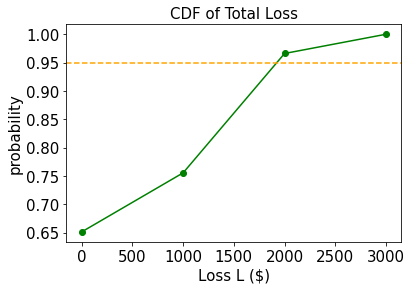

expected loss =  627.473371
var =  2000.5


In [12]:
# plot loss PDF, expected loss, var, and evar
cdf = [np.sum(pdf[0:i+1]) for i in range(len(pdf))]
plt.plot(np.sort(np.unique(losses)), cdf, 'o-g')#, align = "center", width = 90)
#plt.axvline(expected_loss, color="green", linestyle="--", label="E[L]") 
plt.axhline(0.95, color="orange", linestyle="--")#, label="VaR(L)")
 
# plt.legend(fontsize=15)
plt.xlabel("Loss L ($)", size=15)
plt.ylabel("probability", size=15)
plt.title ("CDF of Total Loss", size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

print("expected loss = ", expected_loss)
print("var = ", var)

In [11]:
cdf

[0.651212, 0.75546, 0.966046, 1.0]